# Linear Regression using differents optimizations techniques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
figsize = (20, 7)

## Making the dataset

In [2]:
x, y = make_regression(n_samples=200, n_features=1, noise=7.0, bias=30, random_state=100)
y = y.reshape(y.shape[0], 1)

## Preview of the data

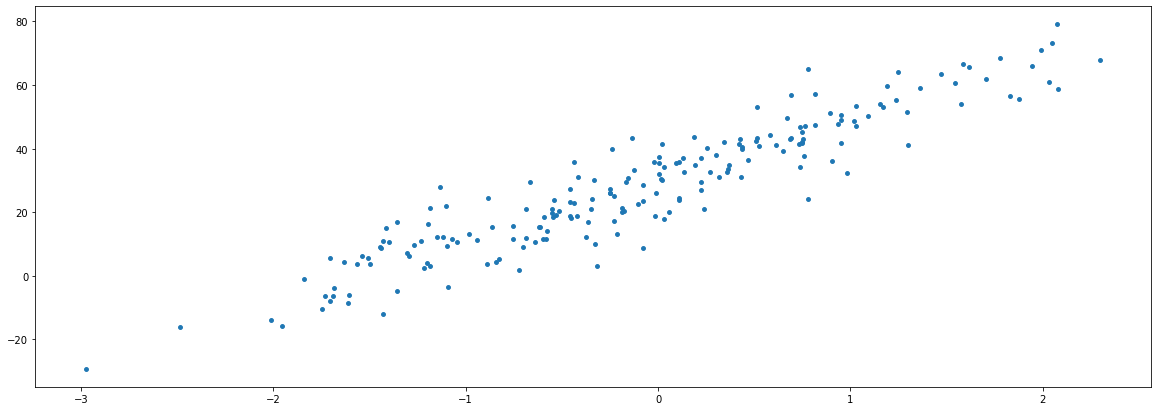

In [3]:
plt.figure(figsize=figsize)
plt.scatter(x, y, s=15)
pass

$\large{X = \begin{bmatrix} x_1 & 1 \\ ... & ... \\ x_m & 1 \end{bmatrix}}$

In [4]:
X = np.hstack([x, np.ones(x.shape)])
print(X.shape)

(200, 2)


$\large{\theta = \begin{bmatrix} a \\ b \end{bmatrix}}$

In [5]:
np.random.seed(0)
theta = np.random.randn(X.shape[1], 1)
print(theta)

[[1.76405235]
 [0.40015721]]


$\large{F = X.\theta}$

In [6]:
def model(X, theta):
    return X.dot(theta)

## Model vs real data

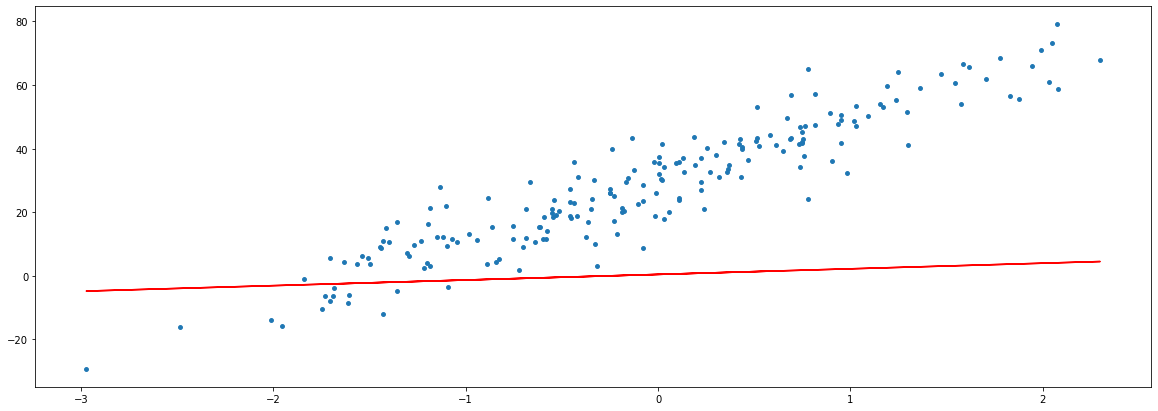

In [7]:
plt.figure(figsize=figsize)
plt.scatter(x, y, s=15)
plt.plot(x, model(X, theta), c='r')
pass

$\large{\epsilon = F - y_i}$

In [8]:
def residuals(X, y, theta):
    return model(X, theta) - y

$\large{J(\theta) = \frac{1}{2m} \displaystyle\sum_{i=1}^m \epsilon^2}$

In [9]:
def loss_function(resi):
    return np.sum(resi**2) / (2*len(resi))

$\large{\frac{\partial J(\theta)}{\partial\theta} = \nabla_{\theta_t} J(\theta_{t,i}) = \frac{1}{m}X^T.\epsilon}$

In [10]:
def gradient(X, y, resi):
    return X.T.dot(resi) / len(y)

## Gradient descent

In [11]:
def descente_gradient(X, y, theta, learning_rate, epochs, batch_size, opti):
    loss_hist = np.zeros(epochs)
    nb_batches = len(y) // batch_size
    broke = False
    opt = opti(learning_rate)
    t = 0
    for i in range(epochs):
        for j in range(nb_batches):
            print(f"Epoch: {i}/{epochs} - Batch: {j}/{nb_batches}", end='\r')
            lower_lim = j*batch_size
            higher_lim = lower_lim + batch_size
            mini_x = X[lower_lim:higher_lim]
            mini_y = y[lower_lim:higher_lim]
            resi = residuals(mini_x, mini_y, theta)
            t += 1
            new_theta = opt.updateTheta(mini_x, mini_y, resi, theta, t)
            if np.isnan(new_theta).any() or not np.isfinite(new_theta).all():
                broke = True
                break
            else:
                theta = new_theta
        if broke:
            print(f"Broke after {i} epochs")
            break
        else:
            loss_hist[i] = loss_function(residuals(X, y, theta))
        
    return theta, loss_hist

## GridSearch CV

In [12]:
def GridSearchCV(epochs, learning_rates, batch_sizes, opt):
    shape = np.array([learning_rates.size, batch_sizes.size])
    res = np.zeros(shape)
    losses = np.zeros([shape[0], shape[1], epochs])
    thetas = np.zeros([shape[0], shape[1], theta.shape[0], 1])
    for i, learning_rate in enumerate(learning_rates):
        for j, batch_size in enumerate(batch_sizes):
            print(f"Training LR: {i}/{shape[0]} = {learning_rate} - BS: {j}/{shape[1]} = {batch_size}")
            theta_final, loss_hist = descente_gradient(X, y, theta, learning_rate, epochs, batch_size, opt)
            thetas[i, j] = theta_final
            res[i, j] = coef_determination(y, model(X, theta_final))
            losses[i, j] = loss_hist
    print(f"Finished training LR: {shape[0]}/{shape[0]} - BS: {shape[1]}/{shape[1]}")
    
    return res, losses, thetas

### Tool to show the best hyper-parameters in a heat-map

In [13]:
def show_best_params(res, losses, learning_rates, batch_sizes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    im = ax1.imshow(res, extent=[0, batch_sizes.size, 0, learning_rates.size], cmap="hot")
    ax1.set_title("R^2")
    ax1.set_xlabel("Batch size")
    ax1.set_xticks(np.arange(0.5, batch_sizes.size + 0.5))
    ax1.set_xticklabels(batch_sizes)
    ax1.set_ylabel("Learning rate")
    ax1.set_yticks(np.arange(0.5, learning_rates.size + 0.5))
    ax1.set_yticklabels(np.flip(learning_rates))

    fig.colorbar(im, ax=ax1, shrink=0.65)

    for i, l1 in enumerate(losses):
        for j, l2 in enumerate(l1):
            ax2.plot(l2, label=f"LR = {learning_rates[i]} | BS = {batch_sizes[j]}")
    ax2.set_title("Loss over epoch")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(loc="upper right")
    plt.show()
    
    args = np.unravel_index(losses.argmin(), losses.shape)
    theta_final = thetas[args[0], args[1]]
    pred = model(X, theta_final)
    print(f"theta: {theta_final.ravel()}")
    print(f"R : {coef_correlation(y, pred)}")
    print(f"R^2: {res[args[0], args[1]]}")
    print(f"Final loss: {losses[args[0], args[1]][-1]}")
    print(f"Meilleur eta: {learning_rates[args[0]]}")
    print(f"Meilleur batch_size: {batch_sizes[args[1]]}")
    
    return args, pred

### Only show best hyper-parameters vs real data

In [14]:
def show_best(args, losses, pred):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.scatter(x, y, s=15)
    ax1.plot(x, pred, c='r')
    ax1.set_title("Evolution de la population mondiale")
    ax1.set_xlabel("Année")
    ax1.set_ylabel("Population mondiale (en milliards)")

    ax2.plot(losses[args[0], args[1]])
    ax2.set_title("Evolution of loss during training")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    pass

## Gradient descent optimization techniques

[Source](https://ruder.io/optimizing-gradient-descent/)

## SGD

- Batch gradient descent

$\large{\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t)}$

- (Real) Stochastic gradient descent

$\large{\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t;x^{(i)};y^{(i)})}$

- Mini-batch Stochastic gradient descent

$\large{\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t;x^{(i:i+n)};y^{(i:i+n)})}$

In [15]:
class SGD:
    def __init__(self, learning_rate=1e-5):
        self.learning_rate = learning_rate
        
    def updateTheta(self, X, y, resi, theta, t):
        return theta - self.learning_rate * gradient(X, y, resi)

## Momentum

$\large{v_t = \gamma v_{t-1} - \eta \nabla_\theta J(\theta_t)} \hspace{0.2cm}$
then
$ \hspace{0.2cm}\large{\theta_{t+1} = \theta_t + v_t}$

In [16]:
class Momentum:
    def __init__(self, learning_rate=1e-5, eta=0.9):
        self.learning_rate = learning_rate
        self.eta = eta
        self.past_vector = 0
        
    def updateTheta(self, X, y, resi, theta, t):
        new_vector = self.eta * self.past_vector - self.learning_rate * gradient(X, y, resi)
        self.past_vector = new_vector
        return theta + new_vector

## Nesterov Accelerated Gradient (NAG)

$\large{v_t = \gamma v_{t-1} - \eta \nabla_\theta J(\theta_t + \gamma v_{t-1})} \hspace{0.2cm}$
then
$\hspace{0.2cm}\large{\theta_{t+1} = \theta_t + v_t}$

In [17]:
class Nesterov:
    def __init__(self, learning_rate=1e-5, eta=0.9):
        self.learning_rate = learning_rate
        self.eta = eta
        self.past_vector = 0
        
    def updateTheta(self, X, y, resi, theta, t):
        v1 = self.eta * self.past_vector
        new_vector = v1 - self.learning_rate * (gradient(X, y, resi) + v1)
        self.past_vector = new_vector
        return theta + new_vector

## Adagrad

With
$\large{g_t = \nabla_{\theta} J(\theta_t)} \hspace{0.2cm}$
the accumulator
$ \hspace{0.2cm} \large{G_t = G_{t-1} + g_t^2} \hspace{0.2cm}$
then
$\hspace{0.2cm} \large{\theta_{t+1} = \theta_t - \eta * \frac{g_t}{\sqrt{G_t + \varepsilon}}}$

In [18]:
class Adagrad:
    def __init__(self, learning_rate=1e-5, initial_accumulator_value=0.1, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.acumm = initial_accumulator_value
        self.epsilon = epsilon
        
    def updateTheta(self, X, y, resi, theta, t):
        g = gradient(X, y, resi)
        self.acumm += g**2
        grad = self.learning_rate * g / np.sqrt(self.acumm + self.epsilon)
        return theta - grad

## Adadelta

With $\large{E[g^2]_0 = 0\hspace{0.2cm}}$ (moment noted $s_t$)$\large{\hspace{1.2cm} E[\Delta \theta^2]_0 = 0\hspace{0.2cm}}$ (variable update)

Step: 

$\large{E[g^2]_t = \rho E[g^2]_{t-1} + (1 - \rho)g^2_t}$

(Original formula)

Given : $\large{RMS[\Delta \theta]_t = \sqrt{E[\Delta \theta^2]_t + \epsilon} \hspace{0.5cm}}$and$\large{\hspace{0.5cm}RMS[\Delta g]_t = \sqrt{E[\Delta g^2]_t + \epsilon}}$

$\large{\Delta \theta_t = \frac{RMS[\Delta \theta]_{t-1}}{RMS[g]_t} \cdot g_t}$

We can simplify the equation with the equality $\large{\frac{\sqrt{a}}{\sqrt{b}} = \sqrt{\frac{a}{b}}}$

(Simplified version)

$\large{\Delta \theta_t = \sqrt{\frac{\Delta \theta_{t-1} + \epsilon}{s_t + \epsilon}} \cdot g_t}$

$\large{\theta_t = \theta_{t-1} - \Delta \theta_t}$

$\large{E[\Delta \theta^2]_t} = \rho E[\Delta \theta^2]_{t-1} + (1-\rho)\Delta \theta^2_t$

In [19]:
class Adadelta:
    def __init__(self, learning_rate=1e-5, rho=0.9, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.rho = rho
        
        self.s_t = 0
        self.delta = 0
        
    def updateTheta(self, X, y, resi, theta, t):
        g = gradient(X, y, resi)
        self.s_t = self.rho * self.s_t + (1 - self.rho) * g**2
        grad = np.sqrt((self.delta + self.epsilon) / (self.s_t + self.epsilon)) * g
        self.delta = self.rho * self.delta + (1 - self.rho) * grad**2
        return theta - grad

## RMSprop

With $\large{E[g^2]_0 = 0 \hspace{0.2cm}}$ (moment noted $s_t$)

Step: 

$\large{E[g^2]_t = \rho E[g^2]_{t-1} + (1 - \rho)g^2_t}$

$\large{\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{E[g^2]_t} + \epsilon} \cdot g_t}$

In [20]:
class RMSprop:
    def __init__(self, learning_rate=1e-5, rho=0.9, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.rho = rho
        
        self.s_t = 0
        
    def updateTheta(self, X, y, resi, theta, t):
        g = gradient(X, y, resi)
        self.s_t = self.rho * self.s_t + (1 - self.rho) * g**2
        grad = (self.learning_rate / (np.sqrt(self.s_t) + self.epsilon)) * g
        return theta - grad

## Adam

$\large{m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t}$

$\large{v_t = \beta_2 v_{t-1} + (1-\beta_2)g^2_t}$

Adam is biased towards zero soo we counteract the biases by computing bias-corrected moment

$\large{\hat{m}_t = \frac{m_t}{1 - \beta^t_1}}$

$\large{\hat{v}_t = \frac{v_t}{1 - \beta^t_2}}$

Finally

$\large{\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t}+\epsilon}\hat{m}_t}$

In [21]:
class Adam:
    def __init__(self, learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
        self.m_t = 0
        self.v_t = 0
        
    def updateTheta(self, X, y, resi, theta, t):
        g = gradient(X, y, resi)
        self.m_t = self.beta_1 * self.m_t + (1 - self.beta_1) * g
        m_hat = self.m_t / (1 - self.beta_1 ** t)
        self.v_t = self.beta_2 * self.v_t + (1 - self.beta_2) * g**2
        v_hat = self.v_t / (1 - self.beta_2 ** t)
        
        grad = self.learning_rate / (np.sqrt(v_hat) + self.epsilon) * m_hat
        return theta - grad

## Coefficient of dertermination

$\large{R^2 = 1 - \frac{SSE}{SST} = 1 - \frac{\displaystyle\sum_{i=0}^m(y_i-\hat{y}_i)^2}{\displaystyle\sum_{i=0}^m(y_i-\bar{y})^2}}$

In [22]:
def coef_determination(y, pred):
    u = ((y - pred)**2).sum()
    v = ((y - y.mean())**2).sum()
    return 1 - u/v

## Coefficient of correlation (Person's correlation)

$\large{R = \frac{Cov(x,y)}{\sigma_x\sigma_y}}$

Note:

$Cov(X,Y) = \frac{1}{m}\displaystyle\sum_{i=1}^m(x_i - \bar{x})(y_i - \bar{y})$

$np.cov(a,b) = \begin{bmatrix} cov(a,a) & cov(a,b) \\ cov(a,b) & cov(b,b) \end{bmatrix}$

In [23]:
def coef_correlation(y, pred):
    cov = ((y-y.mean())*(pred - pred.mean())).sum() / len(y)
    #cov = np.cov(y.ravel(), pred.ravel(), bias=True)[0][1]
    v = y.std() * pred.std()
    return cov/v

# Testing with differents optimzations techniques using GridSearchCV

In [24]:
epochs = 200
learning_rates = np.array([10**-a for a in range(1, 4)])
batch_sizes = np.array([2**b for b in range(0, 7)])

## Testing SGD

In [25]:
res, losses, thetas = GridSearchCV(epochs, learning_rates, batch_sizes, SGD)

Training LR: 0/3 = 0.1 - BS: 0/7 = 1
Training LR: 0/3 = 0.1 - BS: 1/7 = 2
Training LR: 0/3 = 0.1 - BS: 2/7 = 4
Training LR: 0/3 = 0.1 - BS: 3/7 = 8
Training LR: 0/3 = 0.1 - BS: 4/7 = 16
Training LR: 0/3 = 0.1 - BS: 5/7 = 32
Training LR: 0/3 = 0.1 - BS: 6/7 = 64
Training LR: 1/3 = 0.01 - BS: 0/7 = 1
Training LR: 1/3 = 0.01 - BS: 1/7 = 2
Training LR: 1/3 = 0.01 - BS: 2/7 = 4
Training LR: 1/3 = 0.01 - BS: 3/7 = 8
Training LR: 1/3 = 0.01 - BS: 4/7 = 16
Training LR: 1/3 = 0.01 - BS: 5/7 = 32
Training LR: 1/3 = 0.01 - BS: 6/7 = 64
Training LR: 2/3 = 0.001 - BS: 0/7 = 1
Training LR: 2/3 = 0.001 - BS: 1/7 = 2
Training LR: 2/3 = 0.001 - BS: 2/7 = 4
Training LR: 2/3 = 0.001 - BS: 3/7 = 8
Training LR: 2/3 = 0.001 - BS: 4/7 = 16
Training LR: 2/3 = 0.001 - BS: 5/7 = 32
Training LR: 2/3 = 0.001 - BS: 6/7 = 64
Finished training LR: 3/3 - BS: 7/7


### Showing best results

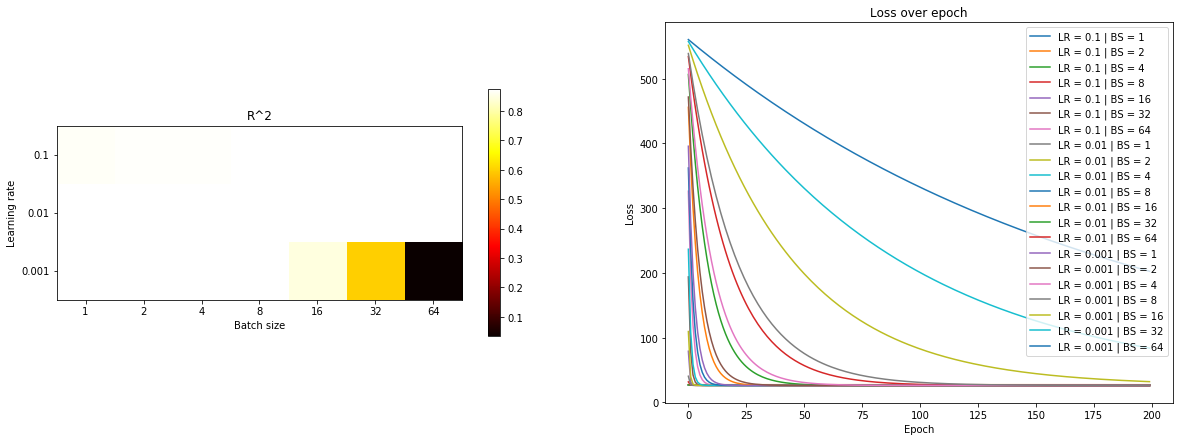

theta: [18.83362067 29.72500795]
R : 0.9354385677207577
R^2: 0.8750422098155433
Final loss: 26.211650241792714
Meilleur eta: 0.01
Meilleur batch_size: 64


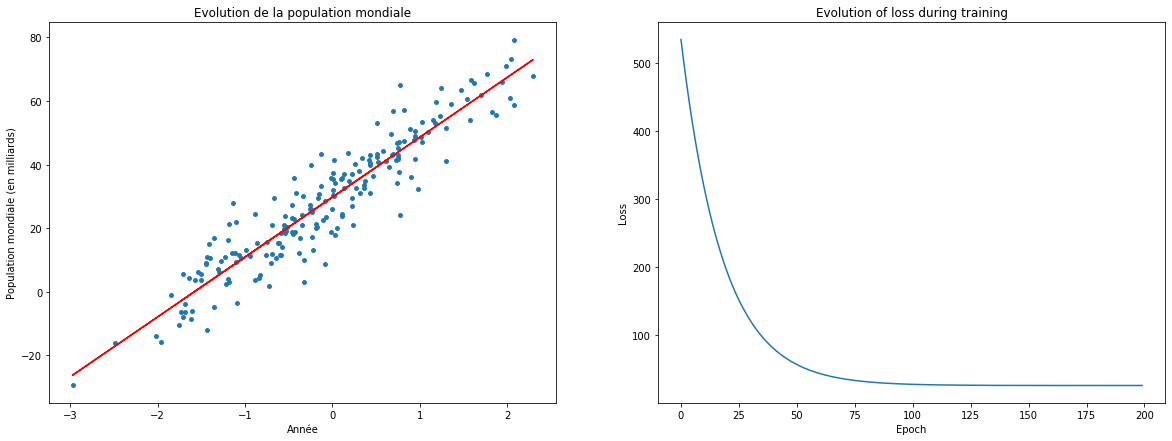

In [26]:
args, pred = show_best_params(res, losses, learning_rates, batch_sizes)
show_best(args, losses, pred)

## Testing Momentum

In [27]:
res, losses, thetas = GridSearchCV(epochs, learning_rates, batch_sizes, Momentum)

Training LR: 0/3 = 0.1 - BS: 0/7 = 1
Training LR: 0/3 = 0.1 - BS: 1/7 = 2
Training LR: 0/3 = 0.1 - BS: 2/7 = 4
Training LR: 0/3 = 0.1 - BS: 3/7 = 8
Training LR: 0/3 = 0.1 - BS: 4/7 = 16
Training LR: 0/3 = 0.1 - BS: 5/7 = 32
Training LR: 0/3 = 0.1 - BS: 6/7 = 64
Training LR: 1/3 = 0.01 - BS: 0/7 = 1
Training LR: 1/3 = 0.01 - BS: 1/7 = 2
Training LR: 1/3 = 0.01 - BS: 2/7 = 4
Training LR: 1/3 = 0.01 - BS: 3/7 = 8
Training LR: 1/3 = 0.01 - BS: 4/7 = 16
Training LR: 1/3 = 0.01 - BS: 5/7 = 32
Training LR: 1/3 = 0.01 - BS: 6/7 = 64
Training LR: 2/3 = 0.001 - BS: 0/7 = 1
Training LR: 2/3 = 0.001 - BS: 1/7 = 2
Training LR: 2/3 = 0.001 - BS: 2/7 = 4
Training LR: 2/3 = 0.001 - BS: 3/7 = 8
Training LR: 2/3 = 0.001 - BS: 4/7 = 16
Training LR: 2/3 = 0.001 - BS: 5/7 = 32
Training LR: 2/3 = 0.001 - BS: 6/7 = 64
Finished training LR: 3/3 - BS: 7/7


### Showing best results

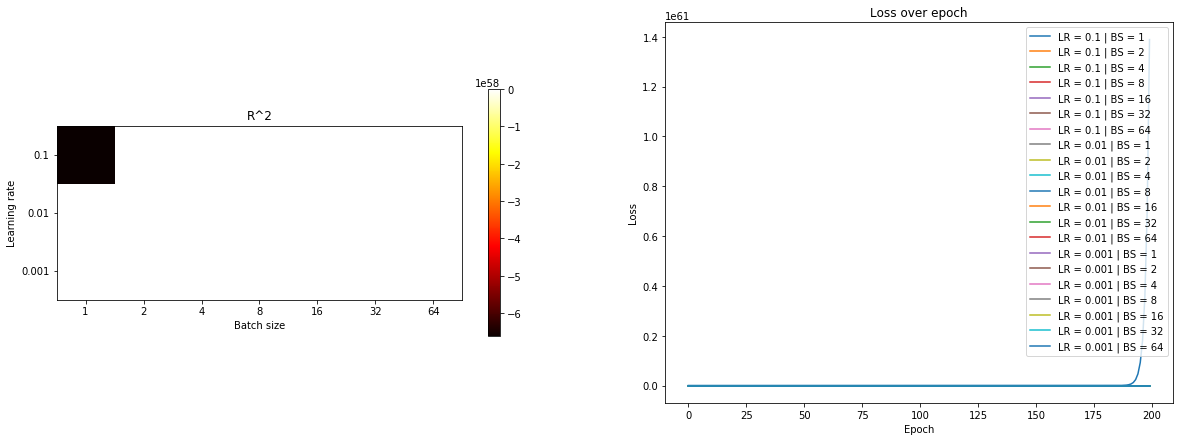

theta: [18.87232947 29.76831307]
R : 0.935438567720758
R^2: 0.8750256146587898
Final loss: 26.215131308830518
Meilleur eta: 0.001
Meilleur batch_size: 64


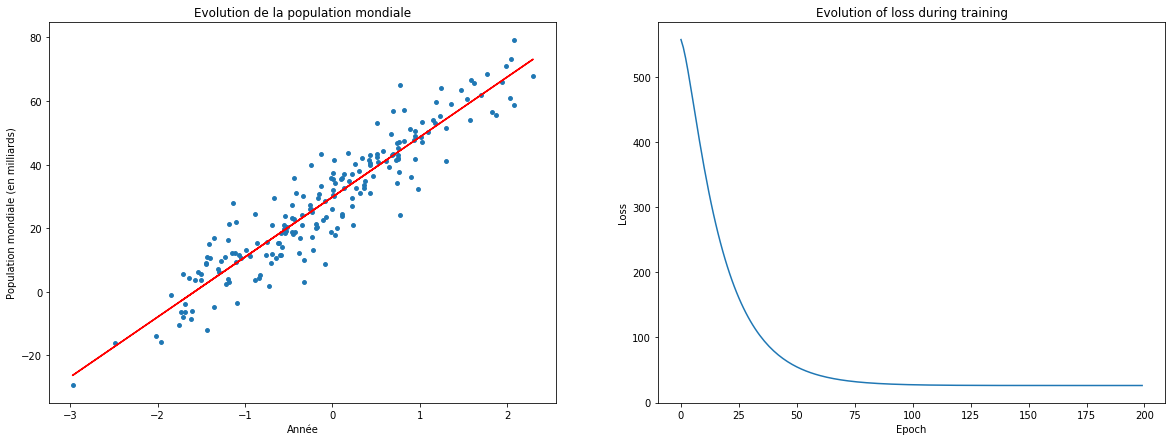

In [28]:
args, pred = show_best_params(res, losses, learning_rates, batch_sizes)
show_best(args, losses, pred)

## Testing Nesterov Accelerated Gradient (NAG)

In [29]:
res, losses, thetas = GridSearchCV(epochs, learning_rates, batch_sizes, Nesterov)

Training LR: 0/3 = 0.1 - BS: 0/7 = 1
Training LR: 0/3 = 0.1 - BS: 1/7 = 2
Training LR: 0/3 = 0.1 - BS: 2/7 = 4
Training LR: 0/3 = 0.1 - BS: 3/7 = 8
Training LR: 0/3 = 0.1 - BS: 4/7 = 16
Training LR: 0/3 = 0.1 - BS: 5/7 = 32
Training LR: 0/3 = 0.1 - BS: 6/7 = 64
Training LR: 1/3 = 0.01 - BS: 0/7 = 1
Training LR: 1/3 = 0.01 - BS: 1/7 = 2
Training LR: 1/3 = 0.01 - BS: 2/7 = 4
Training LR: 1/3 = 0.01 - BS: 3/7 = 8
Training LR: 1/3 = 0.01 - BS: 4/7 = 16
Training LR: 1/3 = 0.01 - BS: 5/7 = 32
Training LR: 1/3 = 0.01 - BS: 6/7 = 64
Training LR: 2/3 = 0.001 - BS: 0/7 = 1
Training LR: 2/3 = 0.001 - BS: 1/7 = 2
Training LR: 2/3 = 0.001 - BS: 2/7 = 4
Training LR: 2/3 = 0.001 - BS: 3/7 = 8
Training LR: 2/3 = 0.001 - BS: 4/7 = 16
Training LR: 2/3 = 0.001 - BS: 5/7 = 32
Training LR: 2/3 = 0.001 - BS: 6/7 = 64
Finished training LR: 3/3 - BS: 7/7


### Showing best results

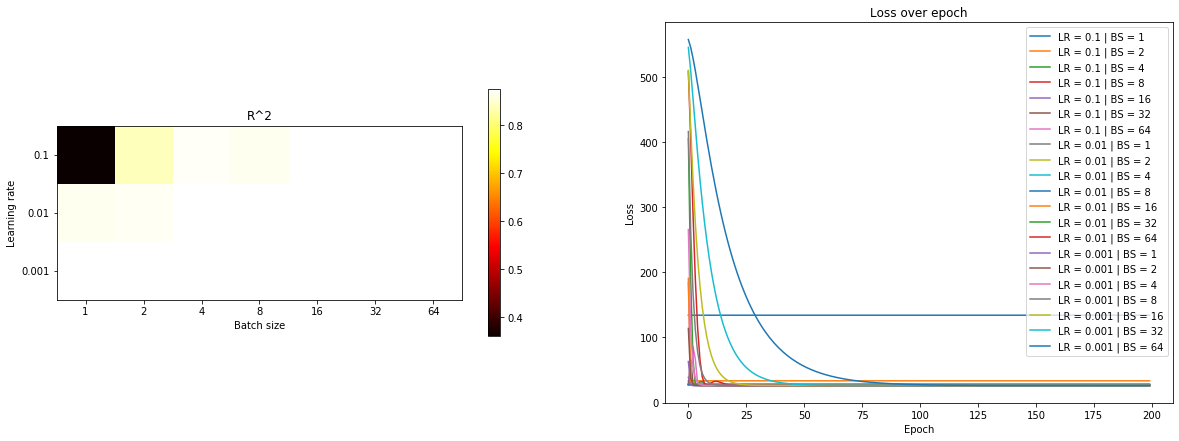

theta: [18.8688057  29.76375256]
R : 0.9354385677207577
R^2: 0.8750279486434086
Final loss: 26.214641722799858
Meilleur eta: 0.001
Meilleur batch_size: 64


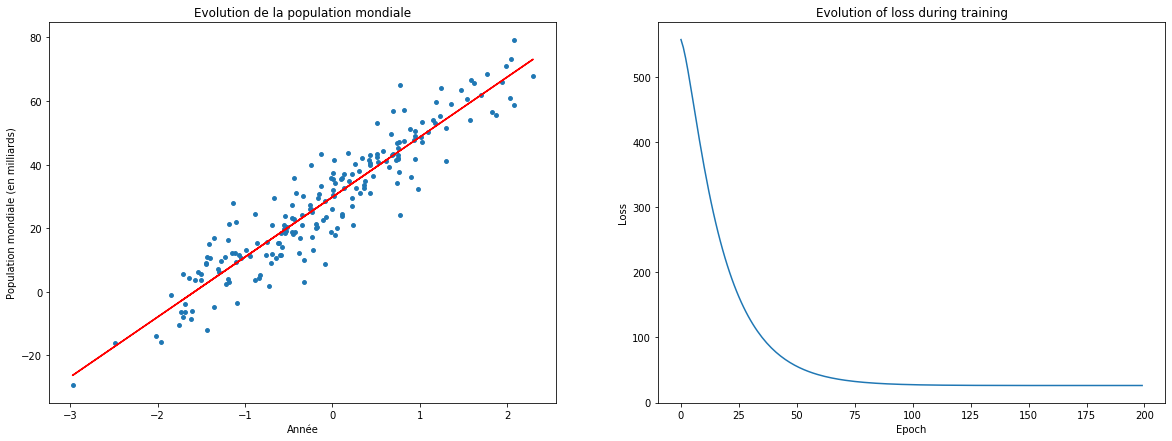

In [30]:
args, pred = show_best_params(res, losses, learning_rates, batch_sizes)
show_best(args, losses, pred)

## Testing Adagrad

In [31]:
res, losses, thetas = GridSearchCV(epochs, learning_rates, batch_sizes, Adagrad)

Training LR: 0/3 = 0.1 - BS: 0/7 = 1
Training LR: 0/3 = 0.1 - BS: 1/7 = 2
Training LR: 0/3 = 0.1 - BS: 2/7 = 4
Training LR: 0/3 = 0.1 - BS: 3/7 = 8
Training LR: 0/3 = 0.1 - BS: 4/7 = 16
Training LR: 0/3 = 0.1 - BS: 5/7 = 32
Training LR: 0/3 = 0.1 - BS: 6/7 = 64
Training LR: 1/3 = 0.01 - BS: 0/7 = 1
Training LR: 1/3 = 0.01 - BS: 1/7 = 2
Training LR: 1/3 = 0.01 - BS: 2/7 = 4
Training LR: 1/3 = 0.01 - BS: 3/7 = 8
Training LR: 1/3 = 0.01 - BS: 4/7 = 16
Training LR: 1/3 = 0.01 - BS: 5/7 = 32
Training LR: 1/3 = 0.01 - BS: 6/7 = 64
Training LR: 2/3 = 0.001 - BS: 0/7 = 1
Training LR: 2/3 = 0.001 - BS: 1/7 = 2
Training LR: 2/3 = 0.001 - BS: 2/7 = 4
Training LR: 2/3 = 0.001 - BS: 3/7 = 8
Training LR: 2/3 = 0.001 - BS: 4/7 = 16
Training LR: 2/3 = 0.001 - BS: 5/7 = 32
Training LR: 2/3 = 0.001 - BS: 6/7 = 64
Finished training LR: 3/3 - BS: 7/7


### Showing best results

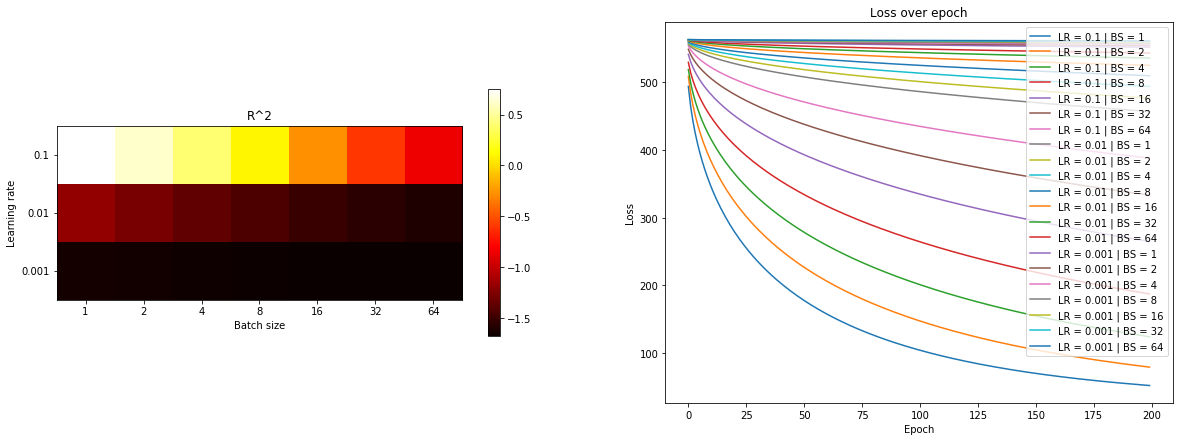

theta: [14.23583428 23.82946397]
R : 0.9354385677207576
R^2: 0.7520424993666669
Final loss: 52.012565777899496
Meilleur eta: 0.1
Meilleur batch_size: 1


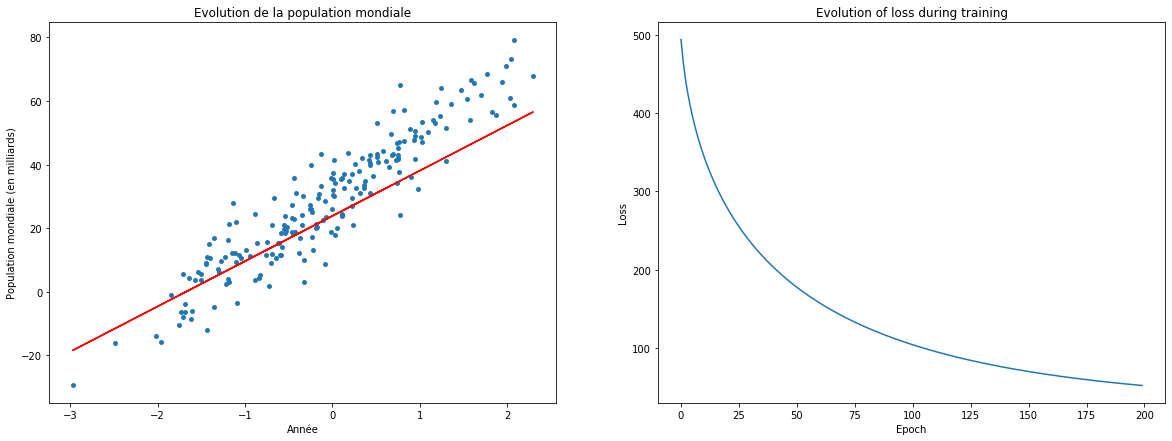

In [32]:
args, pred = show_best_params(res, losses, learning_rates, batch_sizes)
show_best(args, losses, pred)

## Testing Adadelta

In [33]:
res, losses, thetas = GridSearchCV(epochs, learning_rates, batch_sizes, Adadelta)

Training LR: 0/3 = 0.1 - BS: 0/7 = 1
Training LR: 0/3 = 0.1 - BS: 1/7 = 2
Training LR: 0/3 = 0.1 - BS: 2/7 = 4
Training LR: 0/3 = 0.1 - BS: 3/7 = 8
Training LR: 0/3 = 0.1 - BS: 4/7 = 16
Training LR: 0/3 = 0.1 - BS: 5/7 = 32
Training LR: 0/3 = 0.1 - BS: 6/7 = 64
Training LR: 1/3 = 0.01 - BS: 0/7 = 1
Training LR: 1/3 = 0.01 - BS: 1/7 = 2
Training LR: 1/3 = 0.01 - BS: 2/7 = 4
Training LR: 1/3 = 0.01 - BS: 3/7 = 8
Training LR: 1/3 = 0.01 - BS: 4/7 = 16
Training LR: 1/3 = 0.01 - BS: 5/7 = 32
Training LR: 1/3 = 0.01 - BS: 6/7 = 64
Training LR: 2/3 = 0.001 - BS: 0/7 = 1
Training LR: 2/3 = 0.001 - BS: 1/7 = 2
Training LR: 2/3 = 0.001 - BS: 2/7 = 4
Training LR: 2/3 = 0.001 - BS: 3/7 = 8
Training LR: 2/3 = 0.001 - BS: 4/7 = 16
Training LR: 2/3 = 0.001 - BS: 5/7 = 32
Training LR: 2/3 = 0.001 - BS: 6/7 = 64
Finished training LR: 3/3 - BS: 7/7


### Showing best results

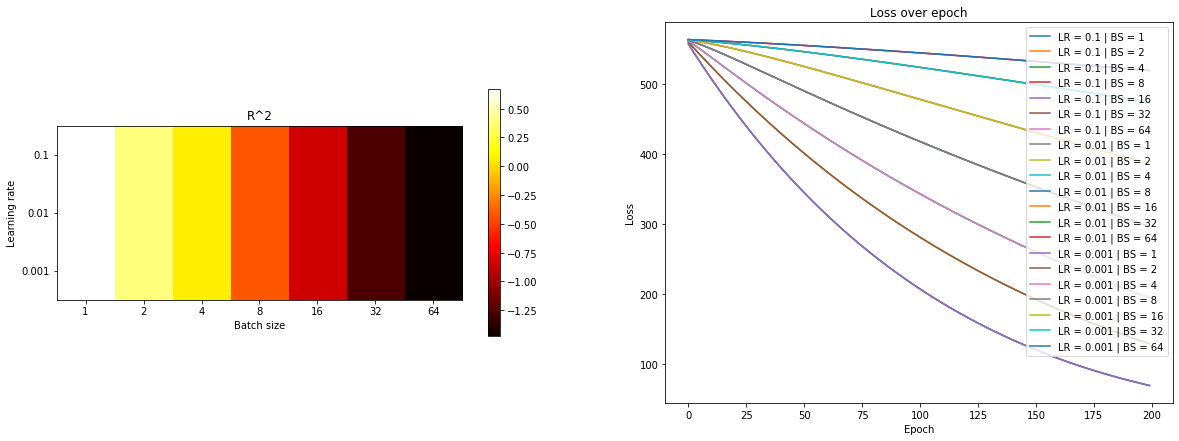

theta: [11.12615456 24.11001808]
R : 0.9354385677207581
R^2: 0.6713637067620595
Final loss: 68.93607483292075
Meilleur eta: 0.1
Meilleur batch_size: 1


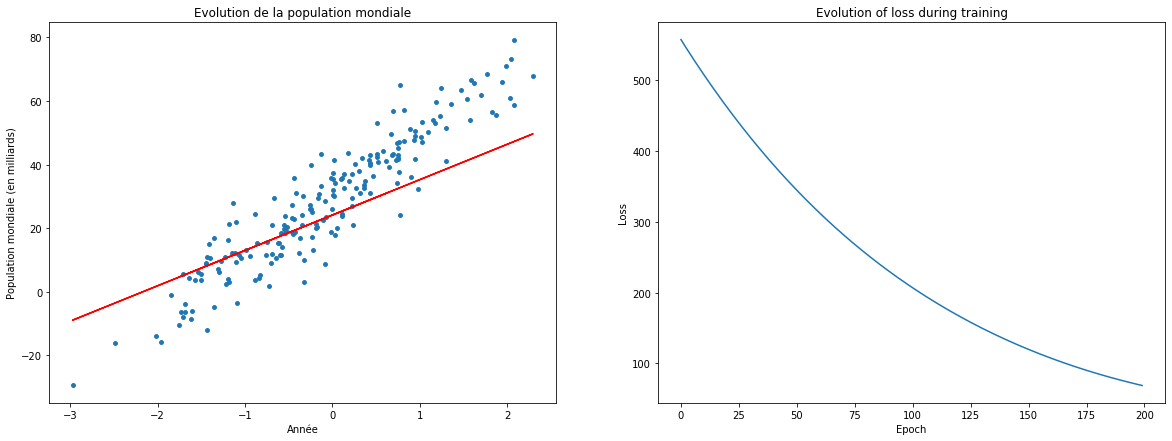

In [34]:
args, pred = show_best_params(res, losses, learning_rates, batch_sizes)
show_best(args, losses, pred)

## Testing RMSprop

In [35]:
res, losses, thetas = GridSearchCV(epochs, learning_rates, batch_sizes, RMSprop)

Training LR: 0/3 = 0.1 - BS: 0/7 = 1
Training LR: 0/3 = 0.1 - BS: 1/7 = 2
Training LR: 0/3 = 0.1 - BS: 2/7 = 4
Training LR: 0/3 = 0.1 - BS: 3/7 = 8
Training LR: 0/3 = 0.1 - BS: 4/7 = 16
Training LR: 0/3 = 0.1 - BS: 5/7 = 32
Training LR: 0/3 = 0.1 - BS: 6/7 = 64
Training LR: 1/3 = 0.01 - BS: 0/7 = 1
Training LR: 1/3 = 0.01 - BS: 1/7 = 2
Training LR: 1/3 = 0.01 - BS: 2/7 = 4
Training LR: 1/3 = 0.01 - BS: 3/7 = 8
Training LR: 1/3 = 0.01 - BS: 4/7 = 16
Training LR: 1/3 = 0.01 - BS: 5/7 = 32
Training LR: 1/3 = 0.01 - BS: 6/7 = 64
Training LR: 2/3 = 0.001 - BS: 0/7 = 1
Training LR: 2/3 = 0.001 - BS: 1/7 = 2
Training LR: 2/3 = 0.001 - BS: 2/7 = 4
Training LR: 2/3 = 0.001 - BS: 3/7 = 8
Training LR: 2/3 = 0.001 - BS: 4/7 = 16
Training LR: 2/3 = 0.001 - BS: 5/7 = 32
Training LR: 2/3 = 0.001 - BS: 6/7 = 64
Finished training LR: 3/3 - BS: 7/7


### Showing best results

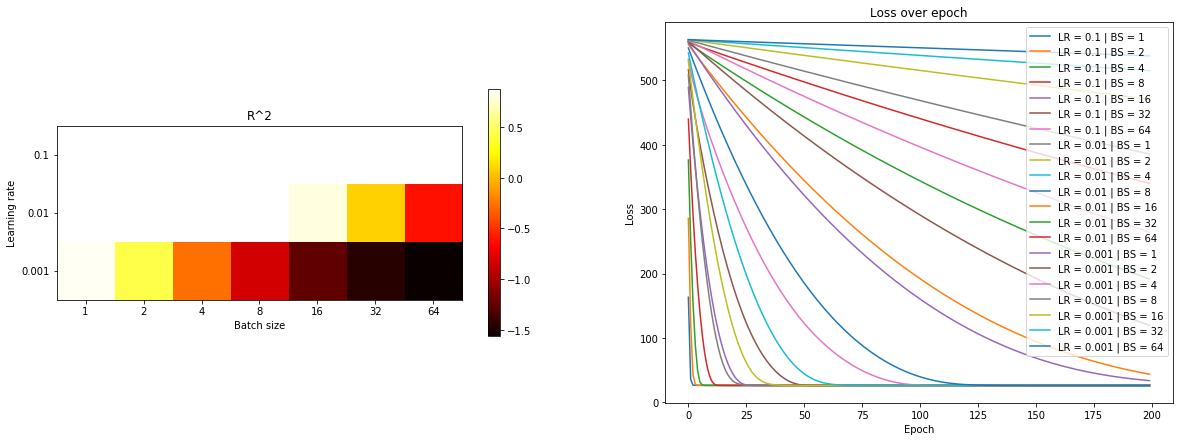

theta: [18.86631483 29.75842655]
R : 0.9354385677207577
R^2: 0.8750301540511225
Final loss: 26.214179107579536
Meilleur eta: 0.1
Meilleur batch_size: 64


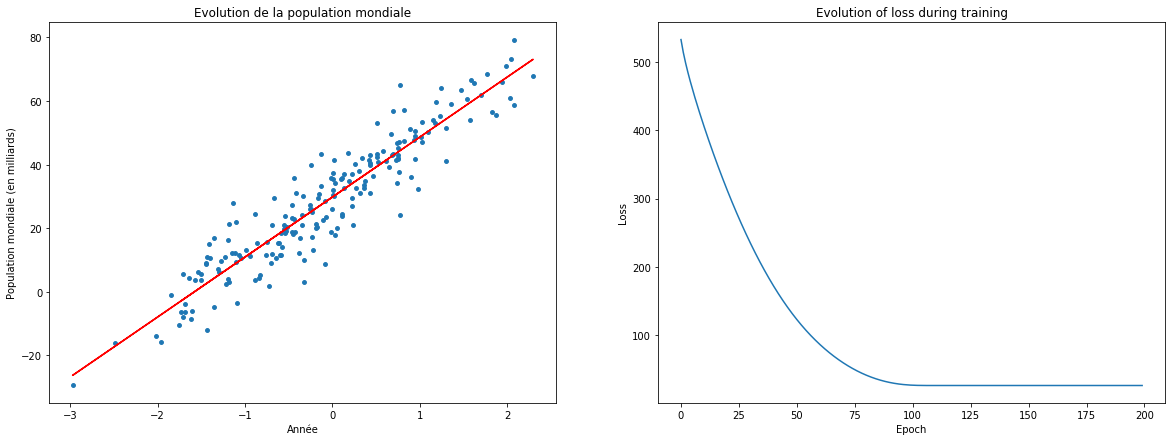

In [36]:
args, pred = show_best_params(res, losses, learning_rates, batch_sizes)
show_best(args, losses, pred)

## Testing Adam

In [37]:
res, losses, thetas = GridSearchCV(epochs, learning_rates, batch_sizes, Adam)

Training LR: 0/3 = 0.1 - BS: 0/7 = 1
Training LR: 0/3 = 0.1 - BS: 1/7 = 2
Training LR: 0/3 = 0.1 - BS: 2/7 = 4
Training LR: 0/3 = 0.1 - BS: 3/7 = 8
Training LR: 0/3 = 0.1 - BS: 4/7 = 16
Training LR: 0/3 = 0.1 - BS: 5/7 = 32
Training LR: 0/3 = 0.1 - BS: 6/7 = 64
Training LR: 1/3 = 0.01 - BS: 0/7 = 1
Training LR: 1/3 = 0.01 - BS: 1/7 = 2
Training LR: 1/3 = 0.01 - BS: 2/7 = 4
Training LR: 1/3 = 0.01 - BS: 3/7 = 8
Training LR: 1/3 = 0.01 - BS: 4/7 = 16
Training LR: 1/3 = 0.01 - BS: 5/7 = 32
Training LR: 1/3 = 0.01 - BS: 6/7 = 64
Training LR: 2/3 = 0.001 - BS: 0/7 = 1
Training LR: 2/3 = 0.001 - BS: 1/7 = 2
Training LR: 2/3 = 0.001 - BS: 2/7 = 4
Training LR: 2/3 = 0.001 - BS: 3/7 = 8
Training LR: 2/3 = 0.001 - BS: 4/7 = 16
Training LR: 2/3 = 0.001 - BS: 5/7 = 32
Training LR: 2/3 = 0.001 - BS: 6/7 = 64
Finished training LR: 3/3 - BS: 7/7


### Showing best results

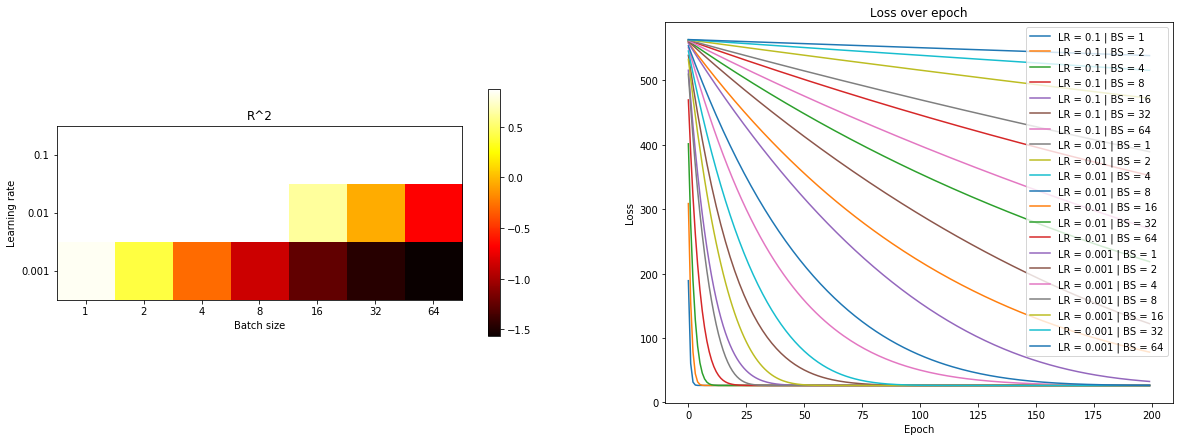

theta: [18.80595403 29.68740929]
R : 0.9354385677207577
R^2: 0.8750449023249367
Final loss: 26.211085450158745
Meilleur eta: 0.01
Meilleur batch_size: 4


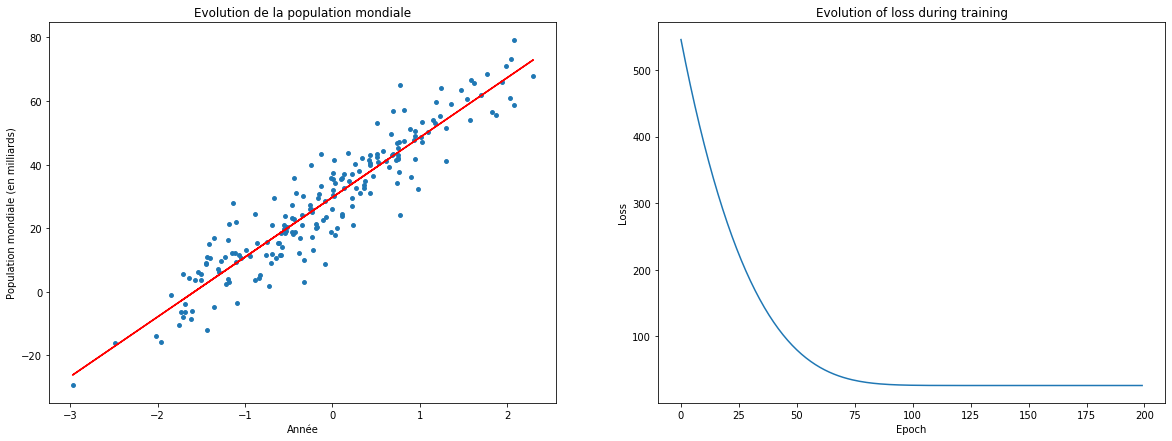

In [38]:
args, pred = show_best_params(res, losses, learning_rates, batch_sizes)
show_best(args, losses, pred)

2020 Pierre Saunders